# Выравнивание ридов относительно референсного генома

Выравниваем риды, изучаем покрытие генома, распределение размеров вставок, строим матрицу нуклеотидных замен

## Задание 0

In [6]:
#!bowtie2-build ./data/MG1655-K12.fasta data/e-coli

In [2]:
#!bowtie2 -x data/e-coli -1 data/100x.1.fastq.gz -2 data/100x.2.fastq.gz -S output.sam 

In [3]:
!samtools flagstat output.sam

5000000 + 0 in total (QC-passed reads + QC-failed reads)
0 + 0 secondary
0 + 0 supplementary
0 + 0 duplicates
4974567 + 0 mapped (99.49% : N/A)
5000000 + 0 paired in sequencing
2500000 + 0 read1
2500000 + 0 read2
4957474 + 0 properly paired (99.15% : N/A)
4959050 + 0 with itself and mate mapped
15517 + 0 singletons (0.31% : N/A)
0 + 0 with mate mapped to a different chr
0 + 0 with mate mapped to a different chr (mapQ>=5)


Percent of mapped reads: 99.49%

In [1]:
import seaborn as sns

sns.set_theme()
sns.set_style("dark")
sns.set_context("notebook")

In [2]:
from Bio import SeqIO

for record in SeqIO.parse("data/MG1655-K12.fasta", "fasta"):
    GENOME = record.seq
    GENOME_LENGTH = len(record.seq)
    break

In [3]:
from collections import defaultdict
import pysam
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt

## Задание 1

In [5]:
one_percent_len = (GENOME_LENGTH // 100) + 1
print(one_percent_len, flush=True)
samfile = pysam.AlignmentFile("output.sam", "rb")

percent_to_coverage = [0 for i in range(100)]
position_to_coverage = np.zeros((GENOME_LENGTH,))

for c, read in tqdm(enumerate(samfile.fetch())):
    if not read.reference_start or not read.reference_end:
        continue
    start_i = read.reference_start // one_percent_len
    end_i = read.reference_end // one_percent_len
    for i in range(start_i, end_i+1):
        percent_to_coverage[i] += read.reference_length / one_percent_len
    for j in range(read.reference_start, read.reference_end):
        position_to_coverage[j] += 1

print("Mean coverage", np.mean(position_to_coverage))
print("Covered percent", np.count_nonzero(position_to_coverage) / position_to_coverage.shape[0])

46397


5000000it [08:15, 10098.41it/s]

Mean coverage 107.21271468367935
Covered percent 0.999999784467662


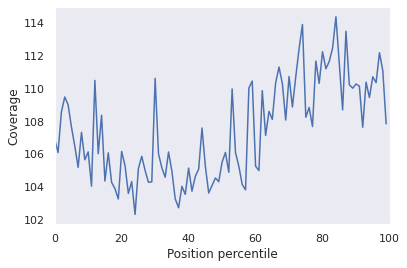

In [17]:
NUMBER_OF_READS = c + 1

plt.plot(range(len(percent_to_coverage)), percent_to_coverage)
plt.xlim(0, 100)

plt.xlabel("Position percentile")
plt.ylabel("Coverage")

plt.show()

# Задание 2

In [11]:
def read_pair_generator(bam, region_string=None):
    """
    Generate read pairs in a BAM file or within a region string.
    Reads are added to read_dict until a pair is found.
    """
    read_dict = defaultdict(lambda: [None, None])
    for read in bam.fetch(region=region_string):
        if not read.is_proper_pair or read.is_secondary or read.is_supplementary:
            continue
        qname = read.query_name
        if qname not in read_dict:
            if read.is_read1:
                read_dict[qname][0] = read
            else:
                read_dict[qname][1] = read
        else:
            if read.is_read1:
                yield read, read_dict[qname][1]
            else:
                yield read_dict[qname][0], read
            del read_dict[qname]

insert_sizes = []
bam = pysam.AlignmentFile("output.sam", 'rb')
for c, (read1, read2) in tqdm(enumerate(read_pair_generator(bam))):
    assert read1.qname == read2.qname
    positions = [read1.reference_start, read1.reference_end, read2.reference_start, read2.reference_end]
    insert_size = max(positions) - min(positions)
    insert_sizes.append(insert_size)

2478737it [00:23, 105090.67it/s]


In [12]:
import collections
counted_sizes = sorted(collections.Counter(insert_sizes).items())
data = list(zip(*counted_sizes))

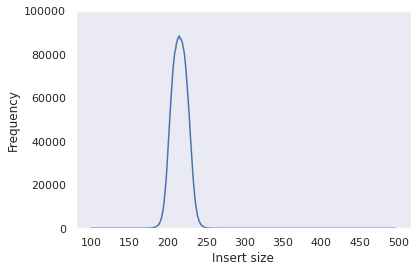

In [13]:
plt.plot(data[0], data[1])
plt.ylim(0, 100000)
plt.xlabel("Insert size")
plt.ylabel("Frequency")
plt.show()

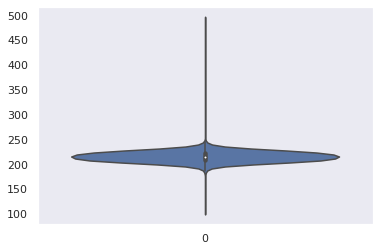

In [29]:
sns.violinplot(data=insert_sizes)
plt.show()

In [25]:
# Mean
print(np.mean(insert_sizes))

215.38676511465314


In [26]:
# STD
print(np.std(insert_sizes))

10.609061193712364


In [31]:
required_num_of_reads = round(len(insert_sizes)*0.95)
sorted_insert_sizes = sorted(insert_sizes)

min_95_interval_scatter = None
min_95_interval = (None, None)

for i in range(len(insert_sizes)-required_num_of_reads):
    min_insert_size = sorted_insert_sizes[i]
    max_insert_size = sorted_insert_sizes[i+required_num_of_reads]
    interval_scatter = max_insert_size - min_insert_size
    if min_95_interval_scatter is None or interval_scatter < min_95_interval_scatter:
        min_95_interval_scatter = interval_scatter
        min_95_interval = min_insert_size, max_insert_size

print("Minimal scatter interval for 95% of reads:", min_95_interval)

Minimal scatter interval for 95% of reads: (195, 233)


# Задание 3

In [6]:
samfile = pysam.AlignmentFile("output.sam", "rb")

range_to_average_coverage = {i: 0 for i in range(100)}

nukes = ["A", "T", "G", "C", "_"]
read_nuc_to_ref_nuc_to_substitution_frequency = {}
for read_nuke in nukes:
    read_nuc_to_ref_nuc_to_substitution_frequency[read_nuke] = {}
    for ref_nuke in nukes:
        read_nuc_to_ref_nuc_to_substitution_frequency[read_nuke][ref_nuke] = 0

mean_error_rate = 0
for c, read in tqdm(enumerate(samfile.fetch())):
    if read.is_secondary or read.is_supplementary or read.reference_id == -1:
        continue
    
    read_errors_num = 0
    read_pairs_num = 0
    for read_pos, ref_pos in read.get_aligned_pairs():
        read_nuc = "_" if read_pos is None else read.query_sequence[read_pos]
        ref_nuc = "_" if ref_pos is None else GENOME[ref_pos]
        
        if read_nuc not in nukes or ref_nuc not in nukes:
            read_errors_num += 1
            read_pairs_num += 1
            continue
            
        if read_nuc != ref_nuc:
            read_errors_num += 1
            read_nuc_to_ref_nuc_to_substitution_frequency[read_nuc][ref_nuc] += 1
        read_pairs_num += 1
    
    if read_pairs_num == 0:
        continue
    read_error_rate = read_errors_num / read_pairs_num * 100
    mean_error_rate = (mean_error_rate*c + read_error_rate) / (c + 1)

5000000it [12:08, 6860.46it/s]


In [7]:
import json
with open("subst_result.json", "w") as f:
    json.dump(read_nuc_to_ref_nuc_to_substitution_frequency, f)

In [10]:
print("{:<15} {:<10} {:<10} {:<10} {:<10} {:<10}".format('Read/Reference', 'A', 'T', 'G', 'C', '_'))
for read_nuc, ref_nuc_to_freq in read_nuc_to_ref_nuc_to_substitution_frequency.items():
    print("{:<15} {:<10} {:<10} {:<10} {:<10} {:<10}".format(read_nuc, ref_nuc_to_freq["A"], ref_nuc_to_freq["T"], ref_nuc_to_freq["G"], ref_nuc_to_freq["C"], ref_nuc_to_freq["_"]))
print()
print("Mean error rate:", str(mean_error_rate) + "%")

Read/Reference  A          T          G          C          _         
A               0          330422     356067     547886     4326      
T               328867     0          548661     350930     4328      
G               757057     1100735    0          630877     8833      
C               1103106    752650     630990     0          8949      
_               1027       950        906        848        0         

Mean error rate: 1.5676493866701933%
